In [1]:
# Packages      to       import
import matplotlib.pyplot as plt
import             pandas as pd
import              numpy as np
import                   random
import                     copy

In [2]:
# Rainfall Properties
dt    =            1/48 #                    time-step [30 mins here]
lbd_v =       0.18 * dt # rainfall frequency converted to 30-min-step
aph_v =          0.0096 #                 mean rainfall depth [meter]
times =               4 #         simulated number of growing seasons 
nd    = 140 * int(1/dt) #       total number of simulated time points

In [3]:
# --- Default soil hydrology parameters ---
soil_defaults = {
    'n'     :         0.43, #  soil               porosity
    'zr'    :          1.0, #  soil                  depth
    'sh'    :         0.14, # hygroscopic            point
    'sw'    :         0.17, # wilting                point
    'sstar' :         0.35, # stomatal    closure    point 
    'sfc'   :         0.59, # field               capacity
    'ET0'   :        0.005, # Reference evapotranspiration
    'evmax' : 1.10 * 0.005, # Max.             evaporation
    'trmax' : 1.03 * 0.005, # Max.           transpiration
    'ks'    :         0.33, # leakage          coefficient
    'rstar' :        0.002, # Interception       threshold
}


# --- Default crop dynamics parameters ---
crop_defaults = {
    'rm'   :       0.200,    # metabolic  limitation  rate
    'gamma':       0.005,    # rate of senescence increase
    'tsen' :         110,    # days until senescence onset
    'Wstar':      0.0337,    # daily  water   productivity
    'rgnc' :       30.24,    # canopy     growth      rate
}


# --- Default microbial respiration parameters ---
microbes_defaults = {
    'CUE' :  0.39,     # carbon       use       efficiency
    'Umax':   0.5,     # maximum  microbial  uptake   rate
    'DOCb':     1,     # bulk       DOC      concentration
    'Ob'  :     1,     # bulk       02       concentration
    'p'   : 0.794,     # collocation                factor
   'mg'   :   1.5,     # O2 diffusion cementation exponent
   'ng'   :     2,     # O2 diffusion  saturation exponent
   'ms'   :   1.5,     # DOC diffusion cementation exponen
   'ns'   :     2,     # DOC diffusion saturation exponent 
   'kdoc' :  0.05,     # Bulk       DOC      concentration
    'ko2' : 0.005,     # Bulk       O2       concentration 
} 

In [4]:
def hr_moisture_function(sg, param, paras): 
    """
    Computes microbial respiration
    Args:
        sg   :        given soil moisture value
        param:        soil hydrology dictionary
        paras: microbial respiration dictionary
    """
    sg   = np.asarray(sg)
    n    =     paras['n']
    CUE  =   param['CUE']
    Umax =  param['Umax']
    DOCb =  param['DOCb']
    Ob   =    param['Ob']
    kdoc =  param['kdoc']
    ko2  =   param['ko2']
    p    =     param['p']
    ms   =    param['ms']
    ns   =    param['ns']
    mg   =    param['mg']
    ng   =    param['ng']

    c1   =   Umax * (1-CUE)
    c2   = DOCb * n**(p*ms)
    c3   =     Ob * (n**mg)

    return np.asarray((c1 * c2 * c3 * sg**(p*ns) * (sg-1)**ng) / ((c2 * sg**(p*ns) + kdoc) * (c3 * (sg-1)**ng + ko2)))

def evaporation_loss(s, sh, c, evmax, sstar):
    """
    Computes evaporation 
    Args:
        s:                               soil moisture
        sstar: soil moisture where ET decreases with s
        sh:                          hygroscopic point
        emax:          maximum evapotranspiration rate
    """
    if 0 <= s <= sh:
        ev = 0
    elif sh< s< sstar:
        ev = evmax*(1-c)*((s-sh)/(sstar-sh))
    else:
        ev = evmax*(1-c)
    return ev


def transpiration_loss(s, sw, sstar, c, trmax):
    """
    Computes transpiration
    Args:
        s    :                          soil moisture
        sstar: soil moisture where T decreases with s
        sw   :                          wilting point 
        emax :        maximum evapotranspiration rate
    """
    if s<=sw:
        tr = 0
    elif sw < s <= sstar:
        tr = trmax * c * ((s-sw)/(sstar-sw))
    else:
        tr = trmax * c
    return tr

def leakage_loss(s, ks):
    """
    Computes transpiration
    Args:
        s:                     soil moisture
        ks: saturated hydraulic conductivity
    """
    if s>1:
        s=1
    return ks * s**13

def canopy(rain, rstar, c):
    """
    Returns the amount of water intercepted by the vegetation canopy
    """
    if rain <= rstar:
        return rain * c
    else:
        return rstar * c

def swb_f_sprinkler(sd, stil, scap, rain, cd, params):
    """
    Returns the updated soil moisture value for a sprinkler irrigation system
    """
    n     =      params["n"]
    zr    =     params["zr"]
    sh    =     params["sh"]
    sw    =     params["sw"]
    sstar =  params["sstar"]
    sfc   =    params["sfc"]
    ET0   =    params["ET0"]
    evmax =  params["evmax"]
    trmax =  params["trmax"]
    ks    =     params["ks"]  
    rstar =  params['rstar']
        
    # Add throughfall to soil moisture
    ci =  canopy(rain, rstar, cd) 
    sd  = sd + (rain-ci)/(n * zr)

    # Losses beyond field capacity
    if sd > sfc:
        sd = sd - leakage_loss(sd, ks)*(dt/(n * zr))

    # Transpiration and evaporation loss   
    Td = transpiration_loss(sd, sw, sstar, cd, trmax) # m/d
    Ed =   evaporation_loss(sd, sh, cd, evmax, sstar) # m/d
       
    # Irrigation input
    Id = 0
    if sd - (Td + Ed)*(dt/(n * zr)) < stil:
        Id = n*zr*(scap - (sd - (Td+Ed)*(dt/(n * zr))))  # in meters
        sd = scap
    else:     
        sd = sd - (Td + Ed)*(dt/(n * zr))
    
    output = {'sd': sd, 'ci':ci, 'Transinter': Td, 'Lossd': Td+Ed, 'Id': Id}
    return output

def cover_dynamics(cg, bg, t, Tg, ET0, parac):
    """
    Returns the updated crop cover and biomass values
    """
    rm    =    parac['rm']
    gamma = parac['gamma']   
    tsen  =  parac['tsen']
    Wstar = parac['Wstar']
    rgnc  =  parac['rgnc']

    # Canopy cover
    if t <= tsen:
        cg = cg + (rgnc * Tg - rm * cg**2) * dt
        
    else:
        cg = cg + (rgnc * Tg - (rm + gamma * (t-tsen)) * cg**2) * dt
    
    # Biomass
    bg = bg + Wstar * (Tg/ET0) * dt
            
    output = {'cg': cg, 'bg': bg} # kg of B/m2
    return output
    
def perturb_dictionary_params(parag, perturb=False):
    """
    Returns the perturbed parameter dictionary if needed
    """
    if not perturb:
        return parag
    
    new_params = {}
    for key, val in parag.items():
        new_params[key] = val * random.uniform(0.9, 1.1)  # ±10% variation
    return new_params

In [5]:
# Loading "times" seasons of the seasonal daily rainfall
rain = np.load('rain_Lubbock_lbd0p18_aphp0096.npy')[0:nd*times]

# Intervention (s1) and target soil moisture (s2) value for the sprinkler system
s1 = 0.25 
s2 = 0.35

In [6]:
# Create objects to receive the results
s_outspr   = np.zeros(nd*times)
res_outspr = np.zeros(nd*times)
ci_outspr  = np.zeros(nd*times)
b_outspr   = np.zeros(nd*times)
c_outspr   = np.zeros(nd*times)
I_outspr   = np.zeros(nd*times)
L_outspr   = np.zeros(nd*times)
T_outspr   = np.zeros(nd*times)
para_season  =               []

# Number of growing seasons
for j in range(times):
    
    # Perturb the parameter values (default : no-perturbation)
    par_soil_season     = perturb_dictionary_params(    soil_defaults)  
    par_crop_season     = perturb_dictionary_params(    crop_defaults)
    par_microbes_season = perturb_dictionary_params(microbes_defaults)
    
    # Merge dictionaries into one parameter dictionary for the model
    combined_params = {"season": j+1, **par_soil_season, **par_crop_season, **par_microbes_season}

    # Append to the list to track
    para_season.append(combined_params)

    # Initialization
    sav0 =   par_soil_season['sstar']
    cav0 =                       0.01
    bav0 =                        0.0

    # Seasonal run
    for i in range(j*nd, j*nd+nd):       

        sav = swb_f_sprinkler(sav0, s1,  s2, rain[i], cav0, par_soil_season)
        cav =  cover_dynamics(cav0, bav0, (i-j*nd)*dt, sav['Transinter'], par_soil_season['ET0'], par_crop_season)

        s_outspr[i]  = sav['sd']
        b_outspr[i]  = cav['bg'] 
        c_outspr[i]  = cav['cg']
        ci_outspr[i] = sav['ci']

        I_outspr[i] =         sav['Id']
        L_outspr[i] =      sav['Lossd']
        T_outspr[i] = sav['Transinter']

        sav0 = sav['sd']
        cav0 = cav['cg']
        bav0 = cav['bg']
        
    res_outspr[j*nd: j*nd+nd] = hr_moisture_function(s_outspr[j*nd : j*nd+nd], par_microbes_season, par_soil_season)

# Convert to DataFrame
params_df = pd.DataFrame(para_season)

In [7]:
# Convert the results to daily timescale
days = np.repeat(np.arange(nd * dt*times), int(1/dt)) + 1

df_result = pd.DataFrame({'Days': days, 'Rain': rain, 'sspr': s_outspr, 'cispr':ci_outspr, 'bspr': b_outspr, 'cspr':  c_outspr,\
                        'res_spr': res_outspr, 'Ispr':  I_outspr, 'Lspr':   L_outspr,   'Tspr':   T_outspr, \
                          })

# Compute daily values
df_daily = df_result.pivot_table(values=['Rain', 'sspr', 'cispr', 'bspr', 'cspr', 'res_spr', 'Ispr', 'Lspr', 'Tspr'],
                                index='Days',
                                aggfunc={'Rain': np.sum,
                                         'sspr': 'last', 'cispr': np.sum, 'bspr': 'last', 'cspr': 'last', 'res_spr': 'last', 'Ispr': np.sum, 'Lspr': np.sum, 'Tspr': np.sum})

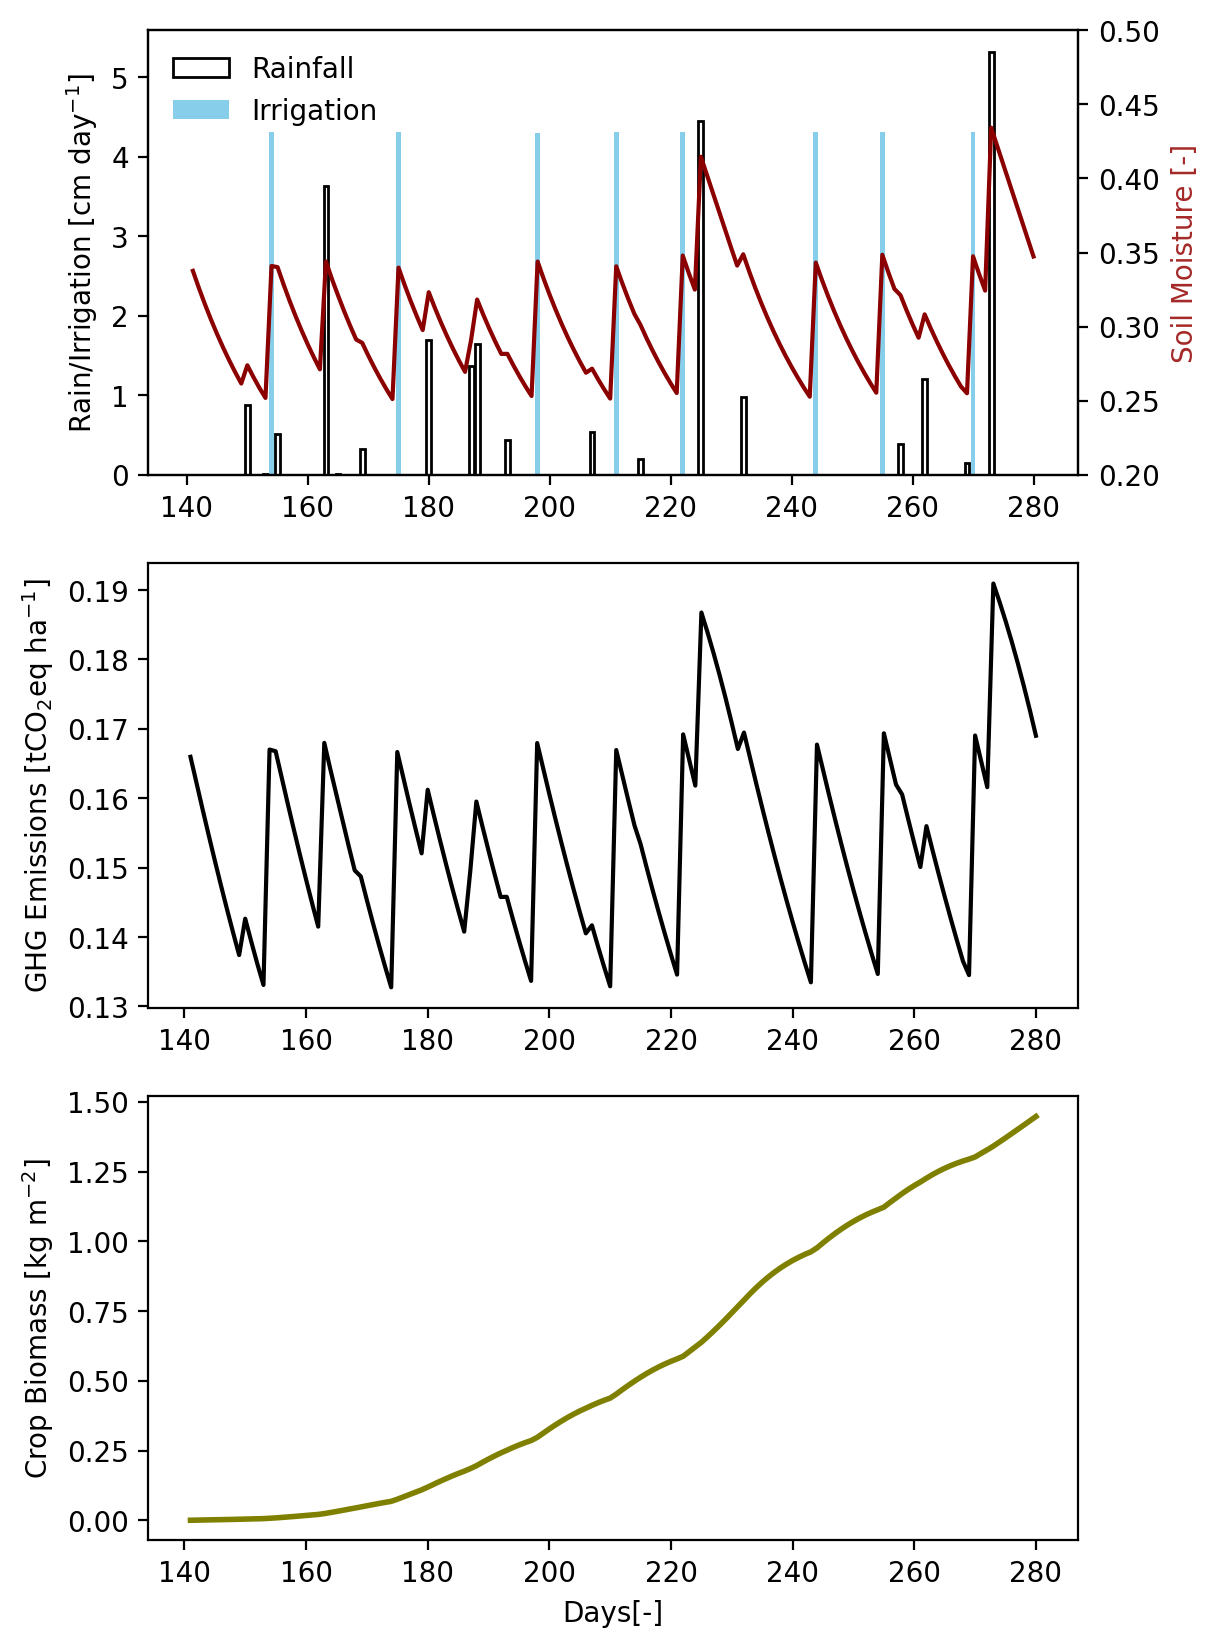

In [8]:
# The k+1th season to visualize

k      =                 1
start  =       int(k*nd*dt)
end    = int(k*nd*dt+nd*dt)
starti =       int(k*nd*dt)
endi   = int(k*nd*dt+nd*dt)

if start!=0:
    start=start+1

fig = plt.figure(figsize=(6, 10), dpi = 200)

# Rain and Irrigation Input
ax1 = fig.add_subplot(311)
ax1.bar(df_daily.index[starti:endi], 100*df_daily.Rain[start:end], edgecolor  = 'k', label =   'Rainfall', fill=False, linewidth=1)
ax1.bar(df_daily.index[starti:endi], 100*df_daily.Ispr[start:end], color = 'skyblue', label = 'Irrigation')
ax1.set_ylabel('Rain/Irrigation [cm day$^{-1}$]')
plt.legend(frameon = False)

# Soil Moisture
ax2 = ax1.twinx()
ax2.plot(df_daily.index[starti:endi], df_daily.sspr[start:end], color = 'darkred')
ax2.set_ylabel('Soil Moisture [-]', color = 'brown')
ax2.set_ylim(0.2,0.5)

# Soil GHG Emissions
ax3 = fig.add_subplot(312)
ax3.plot(df_daily.index[starti:endi], df_daily.res_spr[start:end], color =  'k')
ax3.set_ylabel('GHG Emissions [tCO$_2$eq ha$^{-1}$]')

# Biomass Growth
ax4 = fig.add_subplot(313)
ax4.plot(df_daily.index[starti:endi], df_daily.bspr[start:end], color =  'olive', lw = 2)
ax4.set_ylabel('Crop Biomass [kg m$^{-2}$]')
ax4.set_xlabel('Days[-]')

plt.show()